In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
%matplotlib inline

/home/oalenkin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Data Reading

In [3]:
data = pd.read_csv('../data/hits.csv', index_col=0)
data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,Z,dist2Wire,Wx1,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label
79,2,2.0,-211.0,10002284.0,1,0,0,0,284,0.866347,...,2581.149902,0.042245,-250.000000,250.000000,0.868600,0.868600,2581.1500,2581.1500,2581.1500,0.0
111,2,2.0,-211.0,42012282.0,4,2,0,1,282,0.867240,...,3542.247803,0.478996,-248.589486,249.507863,27.037487,-16.540384,3542.3793,3542.3793,3542.3793,0.0
81,2,2.0,-211.0,11012288.0,1,1,0,1,288,0.866625,...,2592.249023,0.310706,-248.587499,249.509850,-27.060200,16.517671,2592.3793,2592.3793,2592.3793,0.0
43,2,3.0,-13.0,11012286.0,1,1,0,1,286,-0.239448,...,2592.249268,0.117904,-248.894287,249.203062,-23.553595,20.024276,2592.3793,2592.3793,2592.3793,1.0
88,2,2.0,-211.0,20012285.0,2,0,0,1,285,0.866401,...,2782.250977,0.437575,-250.000000,250.000000,-0.011400,-0.011400,2782.2500,2782.2500,2782.2500,0.0


In [4]:
data.columns

Index([u'EventID', u'TrackID', u'PdgCode', u'DetectorID', u'StatNb', u'ViewNb',
       u'PlaneNb', u'LayerNb', u'StrawNb', u'Px', u'Py', u'Pz', u'X', u'Y',
       u'Z', u'dist2Wire', u'Wx1', u'Wx2', u'Wy1', u'Wy2', u'Wz', u'Wz1',
       u'Wz2', u'Label'],
      dtype='object')

# Stage 2.1

Choosing an event

In [584]:
event = data[data.EventID==2]

# Function Initialization

## distance between 2 skew lines

In [585]:
def cross(vec1, vec2):
    return T.as_tensor([
        vec1[1]*vec2[2] - vec1[2]*vec2[1],
        vec1[2]*vec2[0] - vec1[0]*vec2[2],
        vec1[0]*vec2[1] - vec1[1]*vec2[0]])

In [586]:
#arr = np.array(x1, y1, z1, x2, y2, z2)
def points2vec(arr):
    a0 = np.array([arr[0], arr[1], arr[2]])
    a = np.array([arr[3]-arr[0], arr[4]-arr[1], arr[5]-arr[2]])
    return a0, a

In [587]:
a0 = T.vector("my_vector", dtype='float64')
a = T.vector("my_vector", dtype='float64')
b0 = T.vector("my_vector", dtype='float64')
b = T.vector("my_vector", dtype='float64')

In [588]:
dist = T.sqrt(T.sum((a*cross((a0-b0), b))**2))/T.sqrt(T.sum(cross(a,b)**2))

In [589]:
distance_between_skew_lines = theano.function([a0, a, b0, b], dist)

## retina artifitial response

In [590]:
points = T.matrix("points", dtype='float64')
directions = T.matrix("directions", dtype='float64')
track0 = T.vector("track0", dtype='float64')
track = T.vector("track", dtype='float64')
sigma = T.scalar("sigma", dtype="float64")

In [591]:
rs, updates = theano.scan(fn = lambda point, direction, tr0, tr, s:
                         T.exp(-(T.sqrt(T.sum(((point-tr0)*cross(direction, tr))**2))/T.sqrt(T.sum(cross(direction,tr))**2))**2/s**2),
                         sequences=[points, directions],
                         non_sequences=[track0, track, sigma])

In [592]:
r = rs.sum()
R = theano.function([track0, track, points, directions, sigma], r)

# Test

## test distance between 2 skew lines

In [344]:
track1 = event[(event.TrackID==2)&(event.StatNb<3)]
track2 = event[(event.TrackID==3)&(event.StatNb<3)]
noise = event[(event.TrackID!=2)&(event.TrackID!=3)&(event.TrackID<3)]

In [345]:
x0=track1.X.values[0]
x1=track1.X.values[18]
y0=track1.Y.values[0]
y1=track1.Y.values[18]
z0=track1.Z.values[0]
z1=track1.Z.values[18]

In [346]:
track_point, track_direction = points2vec(np.array([x0, y0, z0, x1, y1, z1]))

In [355]:
params = track1[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values[1]
track1.dist2Wire.values[1]

0.31070647120700001

In [356]:
tube_point, tube_direction = points2vec(params)

In [357]:
distance_between_skew_lines(track_point, track_direction, tube_point, tube_direction)

array(0.26907864870815856)

### Distribution of absolute error

In [579]:
real = []
exp = []
for event_i in set(data.EventID.values):
    event = data[data.EventID==event_i]
    track1 = event[(event.TrackID==2)&(event.StatNb<3)]
    if len(track1)>1:
        x0=track1.X.values[0]
        x1=track1.X.values[1]
        y0=track1.Y.values[0]
        y1=track1.Y.values[1]
        z0=track1.Z.values[0]
        z1=track1.Z.values[1]
    else:
        continue
    track_point, track_direction = points2vec(np.array([x0, y0, z0, x1, y1, z1]))
    for i in range(len(track1)):
        params = track1[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values[i]
        tube_point, tube_direction = points2vec(params)
        exp.append(distance_between_skew_lines(track_point, track_direction, tube_point, tube_direction))
        real.append(track1.dist2Wire.values[i])
        
    track2 = event[(event.TrackID==3)&(event.StatNb<3)]
    if len(track2)>1:
        x0=track2.X.values[0]
        x1=track2.X.values[1]
        y0=track2.Y.values[0]
        y1=track2.Y.values[1]
        z0=track2.Z.values[0]
        z1=track2.Z.values[1]
    else:
        continue
    track_point, track_direction = points2vec(np.array([x0, y0, z0, x1, y1, z1]))
    for i in range(len(track2)):
        params = track2[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values[i]
        tube_point, tube_direction = points2vec(params)
        exp.append(distance_between_skew_lines(track_point, track_direction, tube_point, tube_direction))
        real.append(track2.dist2Wire.values[i])

(array([  3.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   5.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   1.00000000e+00,   5.00000000e+00,
          7.00000000e+00,   9.00000000e+00,   1.50000000e+01,
          1.80000000e+01,   2.70000000e+01,   2.30000000e+01,
          3.70000000e+01,   3.30000000e+01,   3.50000000e+01,
          3.80000000e+01,   5.10000000e+01,   7.90000000e+01,
          6.80000000e+01,   1.10000000e+02,   9.90000000e+01,
          1.35000000e+02,   1.98000000e+02,   2.40000000e+02,
          3.12000000e+02,   3.19000000e+02,   4.03000000e+02,
          6.24000000e+02,   6.91000000e+02,   8.68000000e+02,
          1.04500000e+03,   1.18900000e+03,   1.65300000e+03,
        

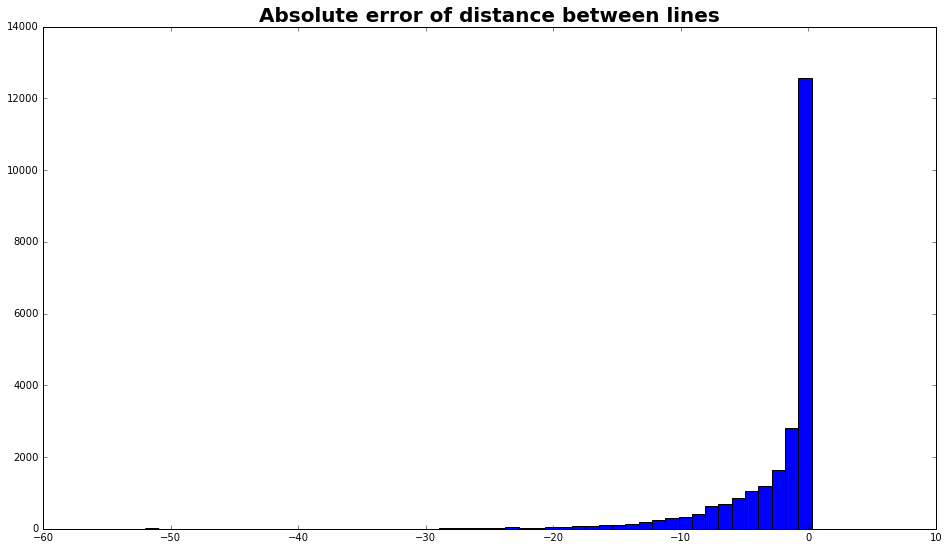

In [581]:
plt.figure(figsize=(16,9))
plt.title("Absolute error of distance between lines", fontsize=20, fontweight='bold')
plt.hist(np.array(real)-np.array(exp), bins=50)

## test retina artifitial response

In [593]:
A0 = []
A = []
for i in range(len(track1.index)):
    a0, a = points2vec(track1[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values[i])
    A0.append(a0)
    A.append(a)
A0 = np.array(A0)
A = np.array(A)

In [597]:
R(track_point, track_direction, A0, A, 10)

array(3.537498612277323e-22)

In [595]:
track1

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,Z,dist2Wire,Wx1,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label
88881,2046,2.0,-211.0,20112244.0,2,0,1,1,244,-0.180964,...,2784.837402,0.364728,-250.000000,250.000000,71.708600,71.708600,2784.8500,2784.8500,2784.8500,0.0
88888,2046,2.0,-211.0,23112243.0,2,3,1,1,243,-0.180703,...,2814.862793,0.397389,-250.000000,250.000000,73.468600,73.468600,2814.8500,2814.8500,2814.8500,0.0
88875,2046,2.0,-211.0,11112243.0,1,1,1,1,243,-0.181414,...,2594.838867,0.228772,-255.451885,242.645464,51.400094,94.977965,2594.9793,2594.9793,2594.9793,0.0
88884,2046,2.0,-211.0,22012250.0,2,2,0,1,250,-0.181068,...,2802.242432,0.273978,-243.680874,254.416475,83.143172,39.565301,2802.3793,2802.3793,2802.3793,0.0
88877,2046,2.0,-211.0,12102253.0,1,2,1,0,253,-0.181182,...,2603.744385,0.148106,-244.256102,253.841247,76.568287,32.990416,2603.8793,2603.8793,2603.8793,0.0
88872,2046,2.0,-211.0,10002248.0,1,0,0,0,248,-0.182039,...,2581.164795,0.337339,-250.000000,250.000000,64.228600,64.228600,2581.1500,2581.1500,2581.1500,0.0
88886,2046,2.0,-211.0,23002243.0,2,3,0,0,243,-0.180967,...,2811.152344,0.076268,-250.000000,250.000000,73.028600,73.028600,2811.1500,2811.1500,2811.1500,0.0
88878,2046,2.0,-211.0,13012248.0,1,3,0,1,248,-0.180940,...,2612.243896,0.141032,-250.000000,250.000000,65.108600,65.108600,2612.2500,2612.2500,2612.2500,0.0
88876,2046,2.0,-211.0,12002253.0,1,2,0,0,253,-0.181193,...,2601.165039,0.390760,-244.217754,253.879595,77.006613,33.428742,2601.2793,2601.2793,2601.2793,0.0
88874,2046,2.0,-211.0,11012243.0,1,1,0,1,243,-0.181375,...,2592.266602,0.337628,-255.490233,242.607116,51.838420,95.416291,2592.3793,2592.3793,2592.3793,0.0


# Stage 2.2

# 2D projections

function converting line from $~~~\frac{x-x_{0}}{l} = \frac{y-y_{0}}{m} = z~~~$ to $~~~\vec{a_{0}}+\overrightarrow{a}$

In [358]:
def params2vec(l, x0, m, y0):
    z1 = 0
    z2 = 1
    x1 = x0
    x2 = 1 * l + x0
    y1 = y0
    y2 = 1 * m + y0
    a0 = np.array([x1, y1, z1])
    a = np.array([x2-x1, y2-y1, z2-z1])
    return a0, a

take hits before magnet only

In [359]:
event_before_magnet = event[event.StatNb<3]

In [360]:
A0 = []
A = []
for i in range(len(event_before_magnet.index)):
    a0, a = points2vec(event_before_magnet[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values[i])
    A0.append(a0)
    A.append(a)
A0 = np.array(A0)
A = np.array(A)

In [559]:
size = 30
ms = np.linspace(-0.2, 0.2, size)
y0s = np.linspace(-100, 100, size)
ls = np.linspace(-0.4, 0.4, size)
x0s = np.linspace(-500, 500, size)

In [560]:
projection_on_yz = np.zeros((len(y0s), len(ms)), dtype="float64")
projection_on_xz = np.zeros((len(x0s), len(ls)), dtype="float64")

In [561]:
for i in range(len(y0s)):
    for j in range(len(ms)):
        max_R = 0
        for s in range(len(x0s)):
            for t in range(len(ls)):
                track_point, track_direction = params2vec(ls[t], x0s[s], ms[j], y0s[i])
                iR = R(track_point, track_direction, A0, A, 20)
                if iR > max_R: max_R = iR
        projection_on_yz[i, j] = max_R

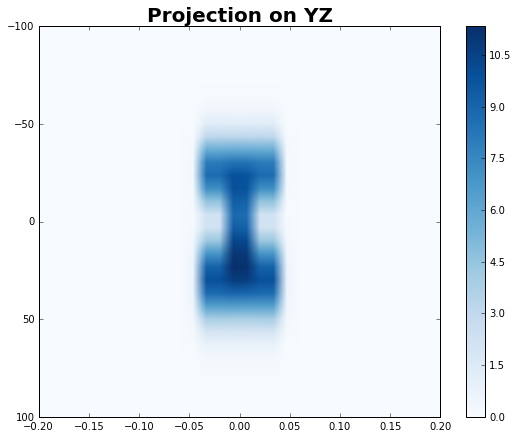

In [567]:
plt.figure(figsize=(9, 7))
plt.title("Projection on YZ", fontsize=20, fontweight='bold')
plt.imshow(projection_on_yz, aspect='auto', cmap="Blues", extent=(ms.min(), ms.max(), y0s.max(), y0s.min()))
plt.colorbar()

In [563]:
for i in range(len(x0s)):
    for j in range(len(ls)):
        max_R = 0
        for s in range(len(y0s)):
            for t in range(len(ms)):
                track_point, track_direction = params2vec(ls[j], x0s[i], ms[t], y0s[s])
                iR = R(track_point, track_direction, A0, A, 20)
                if iR > max_R: max_R = iR
        projection_on_xz[i, j] = max_R

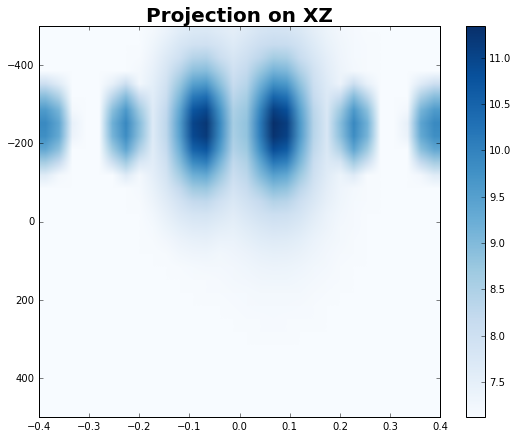

In [568]:
plt.figure(figsize=(9, 7))
plt.title("Projection on XZ", fontsize=20, fontweight='bold')
plt.imshow(projection_on_xz, aspect='auto', cmap="Blues", extent=(ls.min(), ls.max(), x0s.max(), x0s.min()))
plt.colorbar()